In [203]:
import os
import sys
import time
import pickle
import numpy as np
import pandas as pd
from tqdm._tqdm_notebook import tqdm_notebook

from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras import optimizers

# For preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

TIME_STEPS = 60
BATCH_SIZE = 20
EPOCHS = 300

iter_changes = "dropout_layers_0.4_0.4"
OUTPUT_PATH = "./outputs"

# Read file
RESOURCES_PATH = "{}/resources".format(os.getcwd())
df_ge = pd.read_csv(os.path.join(RESOURCES_PATH, "ge_us.txt"), engine='python')

In [204]:
train_cols = ["Open","High","Low","Close","Volume"]
df_train, df_test = train_test_split(df_ge, train_size=0.8, test_size=0.2, shuffle=False)
print("Training set size: {}, Test set size: {}".format(len(df_train), len(df_test)))

Training set size: 11246, Test set size: 2812


In [205]:
# scale the feature MinMax, build array
x = df_train.loc[:,train_cols].values
min_max_scaler = MinMaxScaler()
x_train = min_max_scaler.fit_transform(x)
x_test = min_max_scaler.transform(df_test.loc[:,train_cols])
print("Normalized training set size: {}, Test set size: {}".format(len(x_train), len(x_test)))

Normalized training set size: 11246, Test set size: 2812


In [206]:
print("Deleting unused dataframes of total size: {}KB".format((sys.getsizeof(df_ge)+sys.getsizeof(df_train)+sys.getsizeof(df_test))//1024))

Deleting unused dataframes of total size: 2938KB


In [207]:
del df_ge
del df_train
del df_test
del x

In [208]:
print("Is any NaNs in train/test data set?", np.isnan(x_train).any(), np.isnan(x_test).any())

('Is any NaNs in train/test data set?', False, False)


In [209]:
def build_timeseries(data_set, y_col_index):
    """
    Converts ndarray into timeseries format and supervised data format. Takes first TIME_STEPS
    number of rows as input and sets the TIME_STEPS+1th data as corresponding output and so on.
    :param mat: ndarray which holds the dataset
    :param y_col_index: index of column which acts as output
    :return: returns two ndarrays-- input and output in format suitable to feed
    to LSTM.
    """
    # total number of time-series samples would be len(mat) - TIME_STEPS
    dim_0 = data_set.shape[0] - TIME_STEPS
    dim_1 = data_set.shape[1]
    
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))
    for i in tqdm_notebook(range(dim_0)):
        x[i] = data_set[i:i+TIME_STEPS]
        y[i] = data_set[i+TIME_STEPS, y_col_index]
    print("length of time-series i/o", x.shape, y.shape)
    return x, y

In [210]:
x_t, y_t = build_timeseries(x_train, 3)


('length of time-series i/o', (11186, 60, 5), (11186,))


In [211]:
def trim_dataset(data_set, batch_size):
    """
    trims dataset to a size that's divisible by BATCH_SIZE
    """
    num_of_rows_drop = data_set.shape[0]%batch_size
    if num_of_rows_drop > 0:
        data_set = data_set[:-num_of_rows_drop]
    return data_set

In [212]:
x_t = trim_dataset(x_t, BATCH_SIZE)
y_t = trim_dataset(y_t, BATCH_SIZE)
print("Batch trimmed size",x_t.shape, y_t.shape)

('Batch trimmed size', (11180, 60, 5), (11180,))


In [213]:
x_temp, y_temp = build_timeseries(x_test, 3)
x_val, x_test_t = np.split(trim_dataset(x_temp, BATCH_SIZE),2)
y_val, y_test_t = np.split(trim_dataset(y_temp, BATCH_SIZE),2)
print("Test size", x_test_t.shape, y_test_t.shape, x_val.shape, y_val.shape)


('length of time-series i/o', (2752, 60, 5), (2752,))
('Test size', (1370, 60, 5), (1370,), (1370, 60, 5), (1370,))


In [214]:
def create_model():
    lstm_model = Sequential()
    lstm_model.add(LSTM(100, batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_t.shape[2]),
                        dropout=0.0, recurrent_dropout=0.0, stateful=True, return_sequences=True,
                        kernel_initializer='random_uniform'))
    
    lstm_model.add(Dropout(0.4))
    lstm_model.add(LSTM(60, dropout=0.0))
    lstm_model.add(Dropout(0.4))
    lstm_model.add(Dense(20,activation='relu'))
    lstm_model.add(Dense(1,activation='sigmoid'))
    optimizer = optimizers.RMSprop(lr=0.0001)
    lstm_model.compile(loss='mean_squared_error', optimizer=optimizer)
    return lstm_model

In [215]:
from keras import backend as K
print("Building model...")
print("checking if GPU available", K.tensorflow_backend._get_available_gpus())
model = create_model()
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=40, min_delta=0.0001)

mcp = ModelCheckpoint(os.path.join(OUTPUT_PATH,
                      "best_model.h5"), monitor='val_loss', verbose=1,
                      save_best_only=True, save_weights_only=False, mode='min', period=1)

# Not used here. But leaving it here as a reminder for future
r_lr_plat = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=30, 
                              verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

csv_logger = CSVLogger(os.path.join(OUTPUT_PATH, 'training_log_' + time.ctime().replace(" ","_") + '.log'), append=True)

history = model.fit(x_t, y_t, epochs=EPOCHS, verbose=2, batch_size=BATCH_SIZE,
                    shuffle=False, validation_data=(trim_dataset(x_val, BATCH_SIZE),
                    trim_dataset(y_val, BATCH_SIZE)), callbacks=[es, mcp, csv_logger])

print("saving model...")
pickle.dump(model, open("lstm_model", "wb"))

Building model...
('checking if GPU available', [])
Train on 11180 samples, validate on 1360 samples
Epoch 1/300
 - 30s - loss: 0.0185 - val_loss: 0.0357

Epoch 00001: val_loss improved from inf to 0.03566, saving model to ./outputs/best_model.h5
Epoch 2/300
 - 29s - loss: 0.0049 - val_loss: 0.0025

Epoch 00002: val_loss improved from 0.03566 to 0.00248, saving model to ./outputs/best_model.h5
Epoch 3/300
 - 29s - loss: 0.0015 - val_loss: 0.0023

Epoch 00003: val_loss improved from 0.00248 to 0.00229, saving model to ./outputs/best_model.h5
Epoch 4/300
 - 28s - loss: 0.0014 - val_loss: 0.0020

Epoch 00004: val_loss improved from 0.00229 to 0.00196, saving model to ./outputs/best_model.h5
Epoch 5/300
 - 28s - loss: 0.0013 - val_loss: 0.0017

Epoch 00005: val_loss improved from 0.00196 to 0.00168, saving model to ./outputs/best_model.h5
Epoch 6/300
 - 29s - loss: 0.0012 - val_loss: 0.0015

Epoch 00006: val_loss improved from 0.00168 to 0.00152, saving model to ./outputs/best_model.h5
Epo

In [216]:
y_pred = model.predict(trim_dataset(x_test_t, BATCH_SIZE), batch_size=BATCH_SIZE)
y_pred = y_pred.flatten()
y_test_t = trim_dataset(y_test_t, BATCH_SIZE)
error = mean_squared_error(y_test_t, y_pred)
print("Error is", error, y_pred.shape, y_test_t.shape)
print(y_pred[0:15])
print(y_test_t[0:15])

('Error is', 0.001664756078201761, (1360,), (1360,))
[0.40712535 0.40482047 0.40211764 0.40075338 0.40007663 0.3992446
 0.3996965  0.40135628 0.4033757  0.40515077 0.40627244 0.40613702
 0.40461487 0.40333492 0.40027976]
[0.32378063 0.32499919 0.32800358 0.32905407 0.32905407 0.33031465
 0.32943225 0.33205846 0.32659593 0.32747834 0.31770881 0.31092267
 0.31258244 0.32378063 0.32592362]


In [217]:
# convert the predicted value to range of real data
y_pred_org = (y_pred * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3]
# min_max_scaler.inverse_transform(y_pred)
y_test_t_org = (y_test_t * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3]
# min_max_scaler.inverse_transform(y_test_t)
print(y_pred_org[0:15])
print(y_test_t_org[0:15])

[19.836958 19.727253 19.598606 19.533672 19.501461 19.461859 19.483368
 19.562368 19.658485 19.742973 19.796362 19.789917 19.717466 19.656546
 19.51113 ]
[15.87  15.928 16.071 16.121 16.121 16.181 16.139 16.264 16.004 16.046
 15.581 15.258 15.337 15.87  15.972]


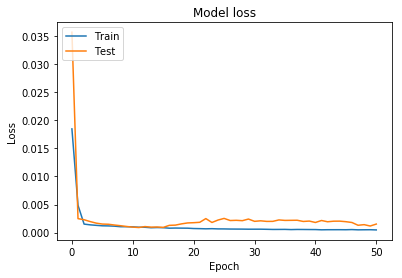

<Figure size 432x288 with 0 Axes>

In [220]:
from matplotlib import pyplot as plt
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
plt.savefig(os.path.join(OUTPUT_PATH, 'train_vis_BS_'+str(BATCH_SIZE)+"_"+time.ctime()+'.png'))

In [221]:
saved_model = load_model(os.path.join(OUTPUT_PATH, 'best_model.h5')) # , "lstm_best_7-3-19_12AM",
print(saved_model)

In [222]:
y_pred = saved_model.predict(trim_dataset(x_test_t, BATCH_SIZE), batch_size=BATCH_SIZE)
y_pred = y_pred.flatten()
y_test_t = trim_dataset(y_test_t, BATCH_SIZE)
error = mean_squared_error(y_test_t, y_pred)
print("Error is", error, y_pred.shape, y_test_t.shape)
print(y_pred[0:15])
print(y_test_t[0:15])
y_pred_org = (y_pred * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3] # min_max_scaler.inverse_transform(y_pred)
y_test_t_org = (y_test_t * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3] # min_max_scaler.inverse_transform(y_test_t)
print(y_pred_org[0:15])
print(y_test_t_org[0:15])

('Error is', 0.0009615639491309342, (1360,), (1360,))
[0.35979712 0.35965234 0.35950196 0.3590652  0.35871944 0.35841593
 0.35804436 0.35759702 0.35725272 0.3570115  0.35698238 0.35751092
 0.35726777 0.35677528 0.35639292]
[0.32378063 0.32499919 0.32800358 0.32905407 0.32905407 0.33031465
 0.32943225 0.33205846 0.32659593 0.32747834 0.31770881 0.31092267
 0.31258244 0.32378063 0.32592362]
[17.584278 17.577387 17.570229 17.54944  17.532984 17.518538 17.50085
 17.479559 17.463171 17.45169  17.450304 17.475462 17.463888 17.440447
 17.422247]
[15.87  15.928 16.071 16.121 16.121 16.181 16.139 16.264 16.004 16.046
 15.581 15.258 15.337 15.87  15.972]


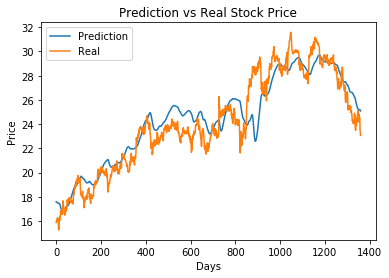

In [226]:
# Visualize the prediction
from matplotlib import pyplot as plt
plt.figure()
plt.plot(y_pred_org)
plt.plot(y_test_t_org)
plt.title('Prediction vs Real Stock Price')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(['Prediction', 'Real'], loc='upper left')
plt.savefig(os.path.join(OUTPUT_PATH, 'pred_vs_real_BS'+str(BATCH_SIZE)+"_"+time.ctime()+'.png'))